In [1]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
# 변환 활성화
pandas2ri.activate()

def import_r_data():
    # 1) 필수 패키지 로드
    ro.r('library(haven)')
    # 2) R-side 데이터 로드
    ro.r('fish <- read_dta("http://www.stata-press.com/data/r11/fish.dta")')
    # 3) Python으로 변환
    fish_df = pandas2ri.rpy2py(ro.r('fish'))
    return fish_df

# 사용 예
fish = import_r_data()
print(type(fish))   # pandas.DataFrame
print(fish.head())

! curl package not installed, falling back to using `url()`
<class 'pandas.core.frame.DataFrame'>
   nofish  livebait  camper  persons  child        xb        zg  count
1     1.0       0.0     0.0      1.0    0.0 -0.896315  3.050405    0.0
2     0.0       1.0     1.0      1.0    0.0 -0.558345  1.746149    0.0
3     0.0       1.0     0.0      1.0    0.0 -0.401731  0.279939    0.0
4     0.0       1.0     1.0      2.0    1.0 -0.956298 -0.601526    0.0
5     0.0       1.0     0.0      1.0    0.0  0.436891  0.527709    1.0


## Single Modal data

In [20]:
def compute_predicted_zero_zipap(model, X, Z):
    model.X = X
    model.Z = Z
    pi, lam = model._pi_lambda()
    T0 = model._T(np.array([0]))
    Z_lam = model._Z(lam)
    p_zero = pi + (1 - pi) * poisson.pmf(0, lam) * T0 / Z_lam
    return np.mean(p_zero)

degrees = [0, 1, 2, 3]

for d in degrees:
    model = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-1)
    model.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)

    # 예측된 Zero 비율
    pred_zero_rate = compute_predicted_zero_zipap(model, X, Z)

    # Poisson 평균 (λᵢ의 평균)
    _, lambda_hat = model._pi_lambda()
    poisson_mean = np.mean(lambda_hat)

    print(f"ZIPAP({d}): Predicted Zero Rate = {pred_zero_rate:.4f}, Poisson Mean = {poisson_mean:.4f}")

ZIPAP(0): Predicted Zero Rate = 0.5822, Poisson Mean = 4.1997
ZIPAP(1): Predicted Zero Rate = 0.5822, Poisson Mean = 4.1997
ZIPAP(2): Predicted Zero Rate = 0.5822, Poisson Mean = 4.0351
ZIPAP(3): Predicted Zero Rate = 0.5773, Poisson Mean = 4.2890


In [21]:
# y_all: 관측값 벡터 (예: y_all = np.array([...]))
pi_obs = np.mean(y_int == 0)
print(f"Observed Zero Rate (π̂): {pi_obs:.4f}")

lambda_obs = np.mean(y_int)
print(f"Observed Poisson Mean (λ̂): {lambda_obs:.4f}")

Observed Zero Rate (π̂): 0.5680
Observed Poisson Mean (λ̂): 3.2960


In [27]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import poisson

# ===========================
# 0) 데이터 로드 및 디자인 행렬 정의
# ===========================
# fish DataFrame이 이미 로드되어 있는 상태라고 가정합니다.
# 예시: fish = pd.read_csv("your_fish_data.csv")

y_int = fish["count"].values.astype(int) # 관측값
X = np.column_stack([np.ones(len(fish)), fish[["persons"]].values]) # 디자인 행렬 X : 여기서 person임
Z = np.column_stack([np.ones(len(fish)), fish[["camper"]].values]) # 디자인 행렬 Z : 여기서 camper임

# ===========================
# 1) ZIPAP 클래스 정의
# ===========================
class ZIPAP:
    def __init__(self, X, Z, degree=3, alpha_init_eps=1e-2):
        self.X = np.asarray(X) # 람다 회귀용
        self.Z = np.asarray(Z) # Pi 회귀용
        self.n, self.p = self.X.shape # 관측치 수 
        _, self.q = self.Z.shape # π 회귀 파라미터 γ의 차원
        self.d = degree # 다항조정자의 차수
        self.beta  = np.zeros(self.p) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.gamma = np.zeros(self.q) #  로그it(π) 회귀용 γ 벡터를 0으로 초기화
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps))) # [1.0]은 alpha_{0}부근, 나머지는 1e-2로 설정하여 알파값이 이상한 값이 나오지 않도록 설정

    def _T(self, y): # propositon 2.2; dentifiability and Validity of the Polynomial Adjuster을 구현한 부분임/
        y = np.asarray(y)
        return sum(self.alpha[k] * (y**k) for k in range(self.d+1)) # 

    def _Z(self, lam):
        lam = np.asarray(lam)
        if self.d <= 4:
            # closed-form moments
            m0 = np.ones_like(lam) # mu0(lambda) =1
            m1 = lam # mu0(lambda) = lambda
            m2 = lam**2 + lam  # mu2(lambda) = lambda^2 + lambda
            
            m3 = lam**3 + 3*lam**2 + lam
            m4 = lam**4 + 6*lam**3 + 7*lam**2 + lam

            Zval = self.alpha[0]*m0 # thm 2.3(c)의 수식으로 풀이 될 수 있음

            # 이때 차수가 d가 0,1,2,3,4일 때를 대비해 필요 모멘트 까지만 더할 수 있도록 한 코드임.
            if self.d>=1: Zval += self.alpha[1]*m1 
            if self.d>=2: Zval += self.alpha[2]*m2
            if self.d>=3: Zval += self.alpha[3]*m3
            if self.d>=4: Zval += self.alpha[4]*m4
            return Zval
        
        # numeric truncation 30 부근까지만 계산해서 보여줘야 함
        Ymax = max(30, int(np.max(lam) + 10*self.d))
        ys = np.arange(Ymax+1)

        # 이를 위한 
        pmf_vals = np.vstack([poisson.pmf(ys, lam_i) for lam_i in lam])
        T_vals = np.vstack([self._T(ys) for _ in lam])

        return (pmf_vals * T_vals).sum(axis=1)
    
    # regresion parameters과 대응됨
    def _pi_lambda(self):
        eta = self.Z.dot(self.gamma) # (logit 링크의 선형 예측자)
        pi = 1/(1+np.exp(-eta)) # logit 링크의 역함수 -> Pi 계산
        lam = np.exp(self.X.dot(self.beta)) # lambda를 양수로 보장하기 위한 로그 링크 연산
        return pi, lam

    def pmf(self, y):
        y = np.asarray(y)
        pi, lam = self._pi_lambda() # _pi_lambda(self) 의 zero inflation parameter pi와 Poisson parameter lambda를 계산값을 호출함
        T_y = self._T(y) # 다항식 가중치 함수 T 계산값에 대해서 호출함.
        Z_l = self._Z(lam) # 정규화 상수 계산값을 호출함
        p = np.zeros_like(y, float) 
        
        # 여기서부터 논문 proposition 2.1 부분의 조건문 분기를 위한 식 생성
        mask0 = (y==0) 

        if mask0.any():
            p0 = poisson.pmf(0, lam[mask0]) * T_y[mask0]/Z_l[mask0] 
            p[mask0] = pi[mask0] + (1-pi[mask0]) * p0
        
        maskp = (y>0) # y가 0보다 큰 경우를 위한 마스크
        if maskp.any():
            pp = poisson.pmf(y[maskp], lam[maskp]) * T_y[maskp]/Z_l[maskp]
            p[maskp] = (1-pi[maskp]) * pp
        return p

    def log_lik(self, theta):
        self.beta = theta[:self.p] # θ에서 beta 파라미터를 추출 -> log lambda 파라미터
        self.gamma = theta[self.p:self.p+self.q] # θ에서 gamma 파라미터를 추출 -> logit pi 파라미터
        self.alpha[1:] = np.abs(theta[self.p+self.q:]) # θ 에서 α₁…α_d 분리 및 비음수 제약 -> 다항조정자 부분 
        vals = np.clip(self.pmf(self._y), 1e-12, None) # f(Yᵢ; θ) 계산, 0으로 나누는 것을 방지하기 위해 최소값을 1e-12로 설정

        return -np.sum(np.log(vals)) # 음의 로그우도 계산
    
    # 초기화 단계: 초기 모멘트 계산
    def init_moments(self, y, alpha_init_eps):
        mu, var = y.mean(), y.var()
        pi0 = np.clip(1 - var/mu, 1e-3, 1-1e-3)
        lam0 = mu/(1-pi0)
        Xmean = self.X.mean(axis=0)
        self.gamma = np.array([np.log(pi0/(1-pi0))] + [0]*(self.q-1))
        self.beta = np.log(lam0) - np.log(Xmean)
        self.alpha = np.concatenate(([1.0], np.full(self.d, alpha_init_eps)))

    def to_theta(self):
        return np.concatenate([self.beta, self.gamma, self.alpha[1:]])

    def fit(self, y, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1):
        self._y = y.copy() # y값을 복사한다.
        self.init_moments(self._y, initial_alpha_eps) # 
        theta0 = self.to_theta() # 초기 파라미터 벡터 θ₀ 생성 여기서 theta0는 beta, gamma, alpha를 포함하는 벡터임.
        
        bounds = [(None,None)]*(self.p+self.q) + [(0,None)]*self.d # β, γ(로그 링크/로그릿 링크)는 아무 값이나 허용 (None,None) / alpha는 양수값 제약
        res = opt.minimize(self.log_lik, theta0, method=method, bounds=bounds) # 최적화 시도 -> method = 'L-BFGS-B'로 설정
        
        if not res.success: # 최적화 실패시 retry_alpha_eps을 사용하여 초기값을 다시 설정함.
            self.init_moments(self._y, retry_alpha_eps)
            res2 = opt.minimize(self.log_lik, self.to_theta(), method=method, bounds=bounds)
            
            # 두 번째 최적화가 성공하면 결과를 업데이트
            if res2.success:
                res = res2
            # 두번째 최적화를 했는데 안되면 Nelder-Mead 기법을 시도
            else:
                res3 = opt.minimize(self.log_lik, self.to_theta(), method='Nelder-Mead')
                if not res3.success:
                    raise RuntimeError("Optimization failed")
                res = res3
        # 최적화 성공시 각 차수에 대한 정보 저장                
        self.beta = res.x[:self.p]
        self.gamma = res.x[self.p:self.p+self.q]
        self.alpha[1:] = np.abs(res.x[self.p+self.q:])
        return res
    
    # 예측 
    def predict_mean(self):
        pi, lam = self._pi_lambda()
        return (1-pi)*lam

    # AIC, BIC 계산
    def aic(self):
        k = self.p + self.q + self.d
        return 2*k + 2*self.log_lik(self.to_theta())

    def bic(self):
        k = self.p + self.q + self.d
        return np.log(self.n)*k + 2*self.log_lik(self.to_theta())

# ===========================
# 2) Table 1: Parameter estimates for ZIP and zPAP models
# ===========================
models = {}
results = {}
degrees = [0,1,2,3]
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-2)
    res = m.fit(y_int, initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    models[d] = m
    # Collect parameter estimates
    params = {
        'beta0': m.beta[0],
        'beta1': m.beta[1],
        'gamma0': m.gamma[0],
        'gamma1': m.gamma[1]
    }
    # alphas
    for k in range(1, d+1):
        params[f'alpha{k}'] = m.alpha[k]
    # stats
    params['logLik'] = -res.fun
    params['AIC'] = m.aic()
    params['BIC'] = m.bic()
    results[d] = params

# Build DataFrame
rows = ['beta0','beta1','gamma0','gamma1','alpha1','alpha2','alpha3','logLik','AIC','BIC']
col_map = {0:'ZIP',1:'zPAP(1)',2:'zPAP(2)',3:'zPAP(3)'}

df = pd.DataFrame(index=rows, columns=[col_map[d] for d in degrees])
for d in degrees:
    for r in rows:
        df.at[r, col_map[d]] = results[d].get(r, np.nan)

# Display table
print("Table 1: MLE estimates for ZIP and zPAP models")
print(df.to_markdown(floatfmt=".3f"))


Table 1: MLE estimates for ZIP and zPAP models
|        |      ZIP |   zPAP(1) |   zPAP(2) |   zPAP(3) |
|:-------|---------:|----------:|----------:|----------:|
| beta0  |   -0.368 |    -0.368 |    -0.368 |    -0.327 |
| beta1  |    0.623 |     0.623 |     0.611 |     0.590 |
| gamma0 |    0.605 |     0.605 |     0.604 |     0.604 |
| gamma1 |   -0.744 |    -0.744 |    -0.745 |    -0.745 |
| alpha1 |  nan     |     0.000 |     0.000 |     0.000 |
| alpha2 |  nan     |   nan     |     0.004 |     0.000 |
| alpha3 |  nan     |   nan     |   nan     |     0.001 |
| logLik | -671.101 |  -671.101 |  -668.619 |  -663.990 |
| AIC    | 1350.201 |  1352.201 |  1349.239 |  1341.981 |
| BIC    | 1364.287 |  1369.808 |  1370.368 |  1366.631 |


Optimization terminated successfully.
         Current function value: 3.686496
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Poisson Mean (λ) from ZIP model: 0.3720
Poisson Mean (λ) from ZIP model: 0.3720
Zero Probability (π) from ZIP model: 0.5670


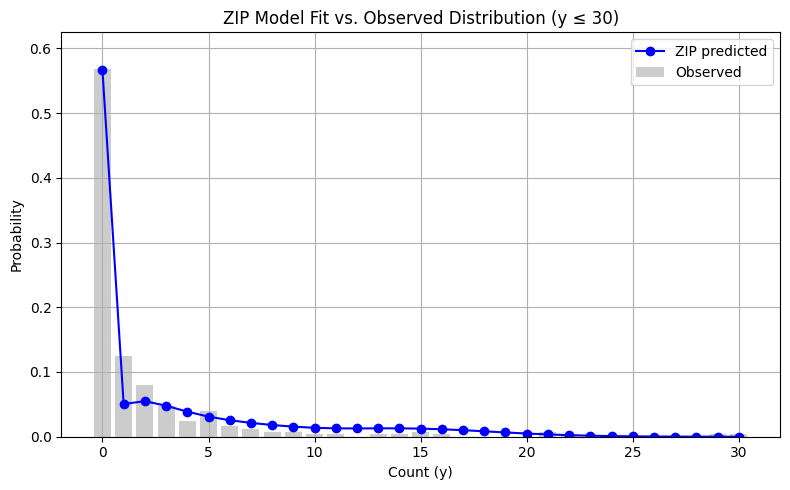

In [34]:
# 1. ZIP 모델 추정
from statsmodels.discrete.count_model import ZeroInflatedPoisson

zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

zip_result.summary()

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

ys = np.arange(0, np.max(y_int) + 1)

# 1. 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=len(ys))
obs_probs = obs_counts / obs_counts.sum()

# 2. ZIP 평균 예측 분포
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)  # shape: (n_samples, n_counts)
zip_probs_avg = np.mean(zip_probs, axis=0)

# 1. 회귀 계수 β 추출 (exog는 count model)
beta_hat = zip_result.params[:X.shape[1]]

# 2. 각 관측치의 λᵢ 계산
lambda_hat = np.exp(X @ beta_hat)

# 3. 평균 λ
lambda_mean = np.mean(lambda_hat)
print(f"Poisson Mean (λ) from ZIP model: {lambda_mean:.4f}")

pi_hat = np.mean(zip_probs[:, 0])
print(f"Zero Probability (π) from ZIP model: {pi_hat:.4f}")

import matplotlib.pyplot as plt
import numpy as np

# 0~30 범위로 설정
ys = np.arange(0, 31)

# 관측 분포
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_probs = obs_counts / obs_counts.sum()

# ZIP 예측 분포 (전체 중 앞 31개)
zip_probs = zip_model.predict(
    params=zip_result.params,
    exog=X,
    exog_infl=Z,
    which='prob'
)
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(ys, obs_probs[:31], width=0.8, alpha=0.4, label="Observed", color="gray")
plt.plot(ys, zip_probs_avg, marker="o", linestyle="-", color="blue", label="ZIP predicted")
plt.xlabel("Count (y)")
plt.ylabel("Probability")
plt.title("ZIP Model Fit vs. Observed Distribution (y ≤ 30)")
plt.ylim(0, max(obs_probs[:31].max(), zip_probs_avg.max()) * 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


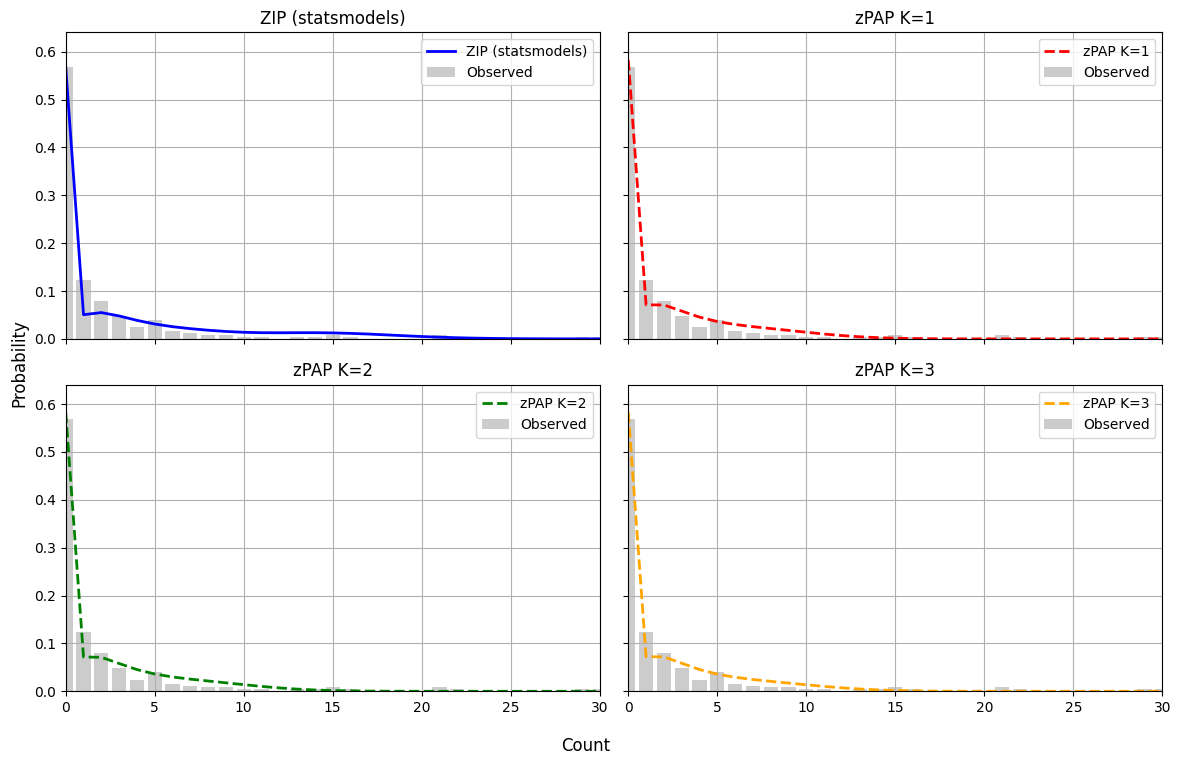

In [35]:
# 0~30 구간만
ys = np.arange(0, 31)

# 관측 빈도
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_freq = obs_counts / obs_counts.sum()

# statsmodels ZIP 예측 확률 (n, y) → 평균
zip_probs = zip_model.predict(params=zip_result.params, exog=X, exog_infl=Z, which='prob')
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]

# zPAP 계열 PMF 추정
def pmf_population(model, y_vals):
    pi, lam = model._pi_lambda()
    Z_l = model._Z(lam)
    out = []
    for y in y_vals:
        T_y = model._T(np.array([y]))
        if y == 0:
            p_i = pi + (1 - pi) * poisson.pmf(0, lam) * T_y / Z_l
        else:
            p_i = (1 - pi) * poisson.pmf(y, lam) * T_y / Z_l
        out.append(p_i.mean())
    return np.array(out)

# 모델 학습 및 PMF
degrees = [1, 2, 3]
colors = {0: "blue", 1: "red", 2: "green", 3: "orange"}
pmfs = {}
for d in degrees:
    m = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-1)
    m.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)
    pmfs[d] = pmf_population(m, ys)

# --- 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# (0, 0) ZIP: statsmodels 예측
ax = axes[0, 0]
ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
ax.plot(ys, zip_probs_avg, label="ZIP (statsmodels)", color="blue", linestyle='-', linewidth=2)
ax.set_title("ZIP (statsmodels)")
ax.set_xlim(0, 30)
ax.set_ylim(0, max(obs_freq.max(), zip_probs_avg.max()) * 1.1)
ax.grid(True); ax.legend()

# 나머지 zPAP(1~3)
for i, d in enumerate(degrees):
    ax = axes[(i+1)//2, (i+1)%2]
    lbl = f"zPAP K={d}"
    ax.bar(ys, obs_freq[:31], color="gray", alpha=0.4, label="Observed")
    ax.plot(ys, pmfs[d], label=lbl, color=colors[d], linestyle='--', linewidth=2)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, max(obs_freq[:31].max(), max(pmfs[d])) * 1.1)
    ax.set_title(lbl)
    ax.grid(True); ax.legend()

fig.supxlabel("Count")
fig.supylabel("Probability")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [39]:
# ===========================
# ZIP 모델 (statsmodels) + zPAP(d) 모델 피팅 후 Table 1 결과 생성 및 시각화
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from scipy.stats import poisson

# statsmodels ZIP 모델 적합
zip_model = ZeroInflatedPoisson(endog=y_int, exog=X, exog_infl=Z, inflation='logit')
zip_result = zip_model.fit()

# ZIP 예측 결과
zip_probs = zip_model.predict(params=zip_result.params, exog=X, exog_infl=Z, which='prob')
zip_probs_avg = np.mean(zip_probs, axis=0)[:31]
beta_hat = zip_result.params[:X.shape[1]]
lambda_hat = np.exp(X @ beta_hat)
lambda_mean = np.mean(lambda_hat)
pi_hat = np.mean(zip_probs[:, 0])

# 관측값 분포 (0~30까지)
ys = np.arange(0, 31)
obs_counts = np.bincount(y_int.astype(int), minlength=31)
obs_probs = obs_counts / obs_counts.sum()

# ===========================
# zPAP(d) 모델 피팅 및 Table 1 결과 생성
# ===========================
results = {0: {
    'beta0': round(beta_hat[0], 3),
    'beta1': round(beta_hat[1], 3),
    'gamma0': round(zip_result.params[X.shape[1]], 3),
    'gamma1': round(zip_result.params[X.shape[1]+1], 3),
    'logLik': round(zip_result.llf, 3),
    'AIC': round(zip_result.aic, 3),
    'BIC': round(zip_result.bic, 3),
}}

for d in [1, 2, 3]:
    model = ZIPAP(X, Z, degree=d, alpha_init_eps=1e-2)
    res = model.fit(y_int, method='L-BFGS-B', initial_alpha_eps=1e-2, retry_alpha_eps=1e-1)

    row = {
        'beta0': round(model.beta[0], 3),
        'beta1': round(model.beta[1], 3),
        'gamma0': round(model.gamma[0], 3),
        'gamma1': round(model.gamma[1], 3),
        'logLik': round(-res.fun, 3),
        'AIC': round(model.aic(), 3),
        'BIC': round(model.bic(), 3),
    }
    for k in range(1, d+1):
        row[f'alpha{k}'] = round(model.alpha[k], 3)
    results[d] = row

# DataFrame 생성 및 출력
columns = ['beta0', 'beta1', 'gamma0', 'gamma1', 'alpha1', 'alpha2', 'alpha3', 'logLik', 'AIC', 'BIC']
df = pd.DataFrame(results).T[columns]
df.index = ['ZIP', 'zPAP(1)', 'zPAP(2)', 'zPAP(3)']
print("Table 1: MLE estimates for ZIP and zPAP models")
print(df.to_markdown(tablefmt="grid"))

Optimization terminated successfully.
         Current function value: 3.686496
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
Table 1: MLE estimates for ZIP and zPAP models
+---------+---------+---------+----------+----------+----------+----------+----------+----------+---------+---------+
|         |   beta0 |   beta1 |   gamma0 |   gamma1 |   alpha1 |   alpha2 |   alpha3 |   logLik |     AIC |     BIC |
+=========+=========+=========+==========+==========+==========+==========+==========+==========+=========+=========+
| ZIP     |   0.623 |  -0.773 |   -0.3   |    0.752 |      nan |  nan     |  nan     | -921.624 | 1851.25 | 1865.33 |
+---------+---------+---------+----------+----------+----------+----------+----------+----------+---------+---------+
| zPAP(1) |  -0.368 |   0.623 |    0.605 |   -0.744 |        0 |  nan     |  nan     | -671.101 | 1352.2  | 1369.81 |
+---------+---------+---------+----------+----------+----------+---------

### ZIPAP Mutlmodal


 d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector
---+---------+---------+--------------+-----------+-------------+------------------------
 0 |  8.2507 |  0.2873 |   -1460.4555 |   2924.91 |  4.2015e-04 | [1.]
 1 |  8.2507 |  0.2873 |   -1460.4555 |   2926.91 |  4.2015e-04 | [1. 0.]
 2 |  8.2507 |  0.2873 |   -1460.4555 |   2928.91 |  4.2015e-04 | [ 1. -0.  0.]
 3 |  6.8084 |  0.2843 |   -1349.3655 |   2708.73 |  1.7536e-04 | [ 1.     -0.2958  0.0237  0.    ]
 4 |  6.1499 |  0.2739 |   -1317.8062 |   2647.61 |  7.6234e-05 | [ 1.000e+00 -6.428e-01  1.525e-01 -1.550e-02  6.000e-04]


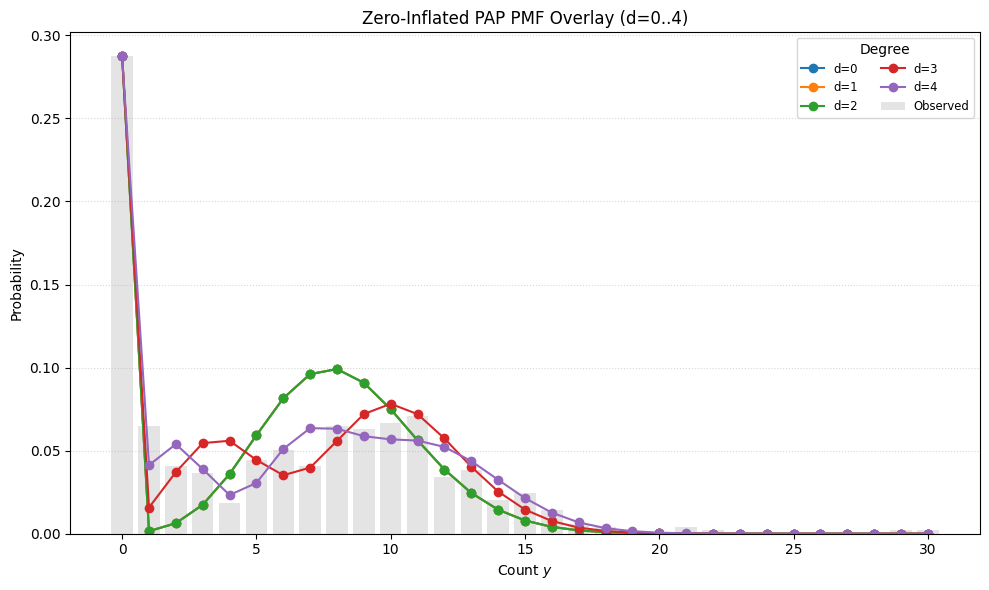

In [40]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from functools import lru_cache

# ============================================================
# 0) 데이터 로드 및 전처리 (y=0..30)
# ============================================================
counts = fish["count"].astype(int).values # fish data 생성
rng    = np.random.RandomState(42) # 랜덤샘플링을 시도할 때 
y_p10  = rng.poisson(lam=10, size=len(counts))

y_all  = np.concatenate([counts, y_p10])
y_all  = y_all[(y_all >= 0) & (y_all <= 30)]   # 0 포함, 상한 30

# ============================================================
# 1) Poisson raw‐moments via Stirling numbers
# ============================================================
# 이전코드에서는 하드코딩으로 모멘트 합을 구했지만, 차후 대용량 데이터를 반영하게 되면 연산량이 많아지게 됨. 그렇기에 스털링 수를 사용해서 빠른 연산이 되도록 도와준다.
# 그냥 모멘트 합이라고 생각하면 쉬움

@lru_cache(None) # 
def S(n, k): # 
    if n==k==0: return 1 # 
    if n==0 or k==0 or k>n: return 0 # 
    return S(n-1, k-1) + k*S(n-1, k) # 


def poisson_raw_moment(j, lam): # 
    lam = np.asarray(lam, float) 
    if j==0: return np.ones_like(lam)
    if j==1: return lam
    if j==2: return lam**2 + lam
    if j==3: return lam**3 + 3*lam**2 + lam
    out = np.zeros_like(lam)
    for k in range(j+1):
        out += S(j,k)*lam**k
    return out

# ============================================================
# 2) SoS 전개로 α 벡터 계산
# ============================================================
# Sum of Square (SoS) 전개를 사용하여 α 벡터를 계산하는 함수
def compute_alpha(u, v):
    r0, r1 = len(u)-1, len(v)-1
    d = max(2*r0, 1+2*r1)
    α = np.zeros(d+1)
    α[0] = 1.0
    # s0^2
    for i in range(r0+1):
        for j in range(r0+1):
            if i==0 and j==0: continue
            α[i+j] += u[i]*u[j]
    # y·s1^2
    for p in range(r1+1):
        for q in range(r1+1):
            α[p+q+1] += v[p]*v[q]
    return α

# ============================================================
# 3) Zero‐Inflated PAP Negative Log‐Likelihood
# ============================================================

def zipap_negloglik(theta, y, r0, r1):
    # unpack
    loglam   = theta[0] # 단일 λ 값을 추정하므로, 그냥 loglam 하나만 가지고 전역 λ 를 np.exp(loglam) 으로 복원
    u1       = theta[1:1+r0]
    v        = theta[1+r0:1+r0+(r1+1)]
    logit_pi = theta[-1]
    lam      = np.exp(loglam) # loglam 은 단일한 로그 Poisson rate 파라미터
    pi       = 1/(1+np.exp(-logit_pi)) # logit_pi 는 단일한 로그릿(zero‐inflation 확률) 파라미터 

    u        = np.concatenate(([1.0], u1)) # u 벡터는 1.0을 포함한 벡터
    α_vec    = compute_alpha(u, v) # 알파연산 함수

    # normalization Z = Σ α_j E[Y^j] -> 정규화 상수 Z(lambdam, alpha)
    Z = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))

    ll = 0.0 # 로그함수 값 초기화
    for yi in y: # 각 관측치에 대해서 계산
        # 다항식 가중치 T(y) 계산 -> SoS 전개를 사용하여 T(y) 계산
        T = u.dot([yi**k for k in range(len(u))])**2
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)

        # PAP‐Poisson 결합 밀도 (unnormalized) 이때 Base rk : 논문 9page 구성
        base = T * poisson.pmf(yi, lam) / Z

        # 0부근 
        if yi==0:
            p = pi + (1-pi)*base
        
        # 0 제외 부분 피팅
        else:
            p = (1-pi)*base
        ll += np.log(p + 1e-16) # 수치적 안정성을 위해서 1e-16을 지정
    
    return -ll # 로그우도 값 생성

class ZIPAP:
    def __init__(self, degree, y):
        self.r0 = degree//2
        self.r1 = (degree-1)//2 if degree>0 else -1
        self.y  = y
        # θ = [loglam, u1..u_r0, v0..v_r1, logit_pi]
        self.theta = np.zeros(1+self.r0+(self.r1+1)+1)

    def fit(self):
        res = minimize(
            zipap_negloglik,
            self.theta,
            args=(self.y, self.r0, self.r1),
            method='L-BFGS-B'
        )
        if not res.success:
            raise RuntimeError("Optimization failed: "+res.message)
        self.theta = res.x
        return res

    def pmf(self, yi):
        loglam   = self.theta[0]
        u1       = self.theta[1:1+self.r0]
        v        = self.theta[1+self.r0:1+self.r0+(self.r1+1)]
        logit_pi = self.theta[-1]
        lam      = np.exp(loglam)
        pi       = 1/(1+np.exp(-logit_pi))
        u        = np.concatenate(([1.0], u1))
        α_vec    = compute_alpha(u, v)
        Z        = sum(α_vec[j]*poisson_raw_moment(j, lam) for j in range(len(α_vec)))
        T        = u.dot([yi**k for k in range(len(u))])**2
        
        if len(v)>0:
            T += yi*(v.dot([yi**k for k in range(len(v))])**2)
        base = T * poisson.pmf(yi, lam) / Z
        return (pi + (1-pi)*base) if yi==0 else (1-pi)*base

# ============================================================
# 4) degree=0..4 모델 학습 & 평가
# ============================================================
y_grid = np.arange(0,31)
hist, _ = np.histogram(y_all, bins=np.arange(-0.5,31.5,1), density=True)

results = []
models  = {}
for d in range(5):
    m = ZIPAP(degree=d, y=y_all)
    res = m.fit()
    models[d] = m

    # 추정된 λ, π
    lam_est = np.exp(m.theta[0])
    pi_est  = 1/(1 + np.exp(-m.theta[-1]))

    ll      = -zipap_negloglik(m.theta, y_all, m.r0, m.r1)
    K       = len(m.theta)
    AIC     = 2*K - 2*ll
    pmf_vals = np.array([m.pmf(yi) for yi in y_grid])
    MSE     = np.mean((hist - pmf_vals)**2)

    # α 벡터
    u1     = m.theta[1:1+m.r0]
    v      = m.theta[1+m.r0:1+m.r0+(m.r1+1)]
    α_vec  = compute_alpha(np.concatenate(([1.0],u1)), v)

    results.append({
        'degree': d,
        'lambda': lam_est,
        'pi': pi_est,
        'logLik': ll,
        'AIC':    AIC,
        'MSE':    MSE,
        'alpha':  α_vec
    })

# 콘솔 테이블 출력
print(" d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector")
print("---+---------+---------+--------------+-----------+-------------+------------------------")
for r in results:
    d, lam, pi, ll, AIC, MSE, α = r['degree'], r['lambda'], r['pi'], r['logLik'], r['AIC'], r['MSE'], r['alpha']
    print(f"{d:2d} | {lam:7.4f} | {pi:7.4f} | {ll:12.4f} | {AIC:9.2f} | {MSE:11.4e} | {np.round(α,4)}")

# ============================================================
# 5) PMF 오버레이 플롯 (ZIPAP d=0..4)
# ============================================================
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, color='lightgray', alpha=0.6, label='Observed')
for d, mdl in models.items():
    pmf_d = [mdl.pmf(yi) for yi in y_grid]
    plt.plot(y_grid, pmf_d, marker='o', label=f'd={d}')
plt.xlabel('Count $y$')
plt.ylabel('Probability')
plt.title('Zero‐Inflated PAP PMF Overlay (d=0..4)')
plt.legend(title='Degree', fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


 d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector
---+---------+---------+--------------+-----------+-------------+------------------------
 0 |  8.2507 |  0.2873 |   -1460.4555 |   2924.91 |  4.2015e-04 | [1.]
 4 |  6.1499 |  0.2739 |   -1317.8062 |   2647.61 |  7.6234e-05 | [ 1.000e+00 -6.428e-01  1.525e-01 -1.550e-02  6.000e-04]


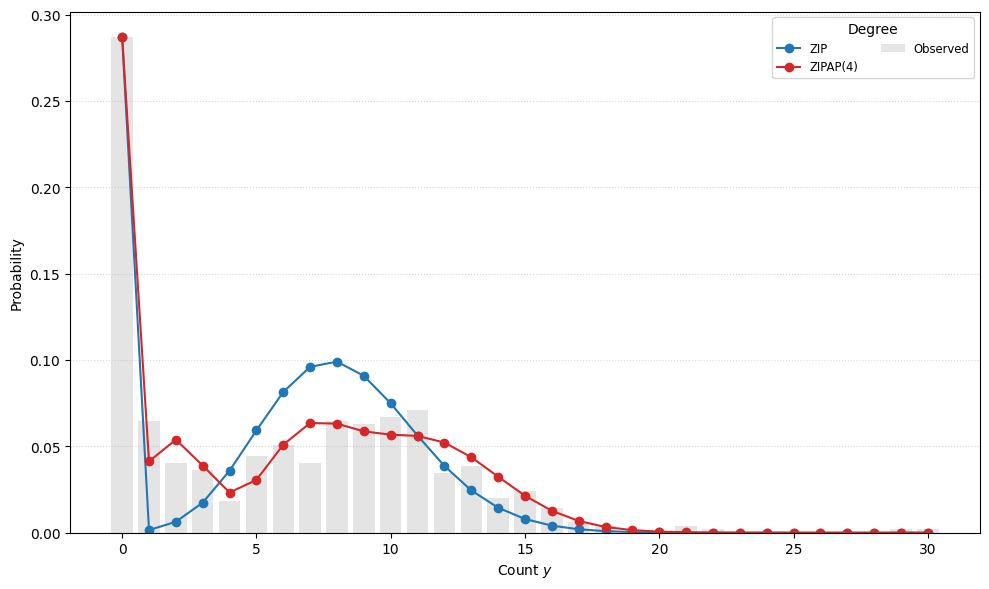

In [43]:
# ============================================================
# 5) 콘솔 테이블 출력 (degree 0과 4만)
# ============================================================
print(' d | lambda  |   pi    |    logLik    |    AIC    |     MSE     |       α vector')
print('---+---------+---------+--------------+-----------+-------------+------------------------')
for r in results:
    if r['degree'] in (0, 4):
        d, lam, pi, ll, AIC, MSE, α = r['degree'], r['lambda'], r['pi'], r['logLik'], r['AIC'], r['MSE'], r['alpha']
        print(f'{d:2d} | {lam:7.4f} | {pi:7.4f} | {ll:12.4f} | {AIC:9.2f} | {MSE:11.4e} | {np.round(α,4)}')

# ============================================================
# 6) PMF 오버레이 플롯 (ZIPAP d=0 and 4 only)
# ============================================================
plt.figure(figsize=(10,6))
plt.bar(y_grid, hist, width=0.8, color='lightgray', alpha=0.6, label='Observed')
for d in (0, 4):
    mdl = models[d]
    pmf_d = [mdl.pmf(yi) for yi in y_grid]
    if d == 0:
        plt.plot(y_grid, pmf_d, marker='o', label='ZIP', color='C0')
    else:
        plt.plot(y_grid, pmf_d, marker='o', label=f'ZIPAP({d})', color='C3')
plt.xlabel('Count $y$')
plt.ylabel('Probability')
plt.legend(title='Degree', fontsize='small', ncol=2)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

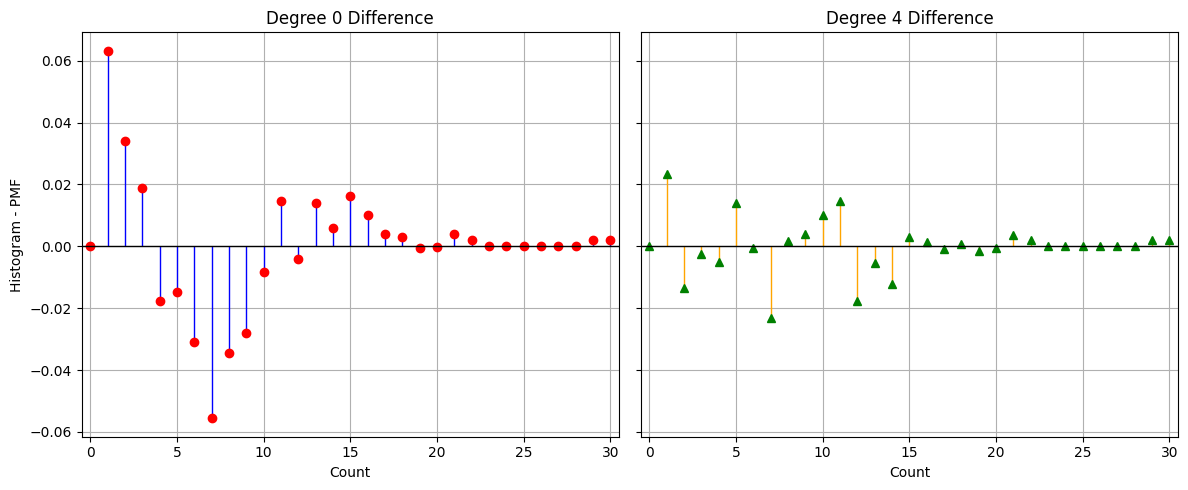

In [44]:
# ============================================================
# 7) 차이 플롯 (Histogram - PMF for degree 0 vs 4)
# ============================================================
# y support 및 히스토그램 (0부터 30까지)
y_grid_diff = np.arange(0, 31)
hist_diff, _ = np.histogram(y_all, bins=np.arange(-0.5, 31.5), density=True)

# 모델별 PMF 계산
pmf0 = np.array([models[0].pmf(yi) for yi in y_grid_diff])
pmf4 = np.array([models[4].pmf(yi) for yi in y_grid_diff])

# 차이 계산
diff_0 = hist_diff - pmf0
diff_4 = hist_diff - pmf4

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# degree=0 (ZIP)
axs[0].vlines(y_grid_diff, 0, diff_0, color='blue', linewidth=1)
axs[0].plot(y_grid_diff, diff_0, 'ro', markersize=6)
axs[0].axhline(0, color='black', linewidth=1)
axs[0].set_xlim(-0.5, 30.5)
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Histogram - PMF')
axs[0].set_title('Degree 0 Difference')
axs[0].grid(True)

# degree=4 (ZIPAP)
axs[1].vlines(y_grid_diff, 0, diff_4, color='orange', linewidth=1)
axs[1].plot(y_grid_diff, diff_4, 'g^', markersize=6)
axs[1].axhline(0, color='black', linewidth=1)
axs[1].set_xlim(-0.5, 30.5)
axs[1].set_xlabel('Count')
axs[1].set_title('Degree 4 Difference')
axs[1].grid(True)

plt.tight_layout()
plt.show()

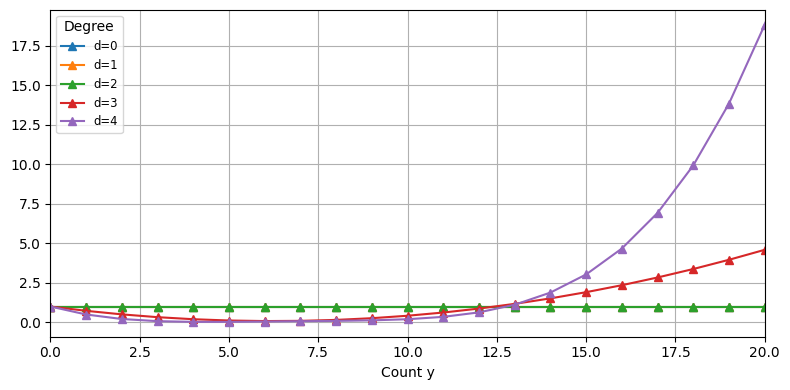

In [45]:
# ============================================================
# 8) T(y) 함수 플롯 (y ≤ 20)
# ============================================================
maskR = y_grid <= 20

plt.figure(figsize=(8, 4))
for d in range(5):  # degree 0~4
    # α 벡터 추출
    α_vec = results[d]['alpha']
    # T(y) = Σ_j α_j * y^j
    T_vals = sum(α_vec[j] * y_grid**j for j in range(len(α_vec)))
    plt.plot(
        y_grid[maskR],
        T_vals[maskR],
        label=f'd={d}',
        marker='^',
        linestyle='-'
    )

plt.xlabel('Count y')
plt.xlim(0, 20)
plt.grid(True)
plt.legend(title='Degree', fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [46]:
for d in range(5):
    lam_d  = results[d]['lambda']
    pi_d   = results[d]['pi']
    alpha_d = results[d]['alpha']
    Z_d    = sum(alpha_d[j] * poisson_raw_moment(j, lam_d)
                 for j in range(len(alpha_d)))
    base0  = np.exp(-lam_d) / Z_d
    p0     = pi_d + (1 - pi_d) * base0
    print(f"d={d}: λ={lam_d:.4f}, π={pi_d:.4f}, p(y=0)={p0:.4f}")

d=0: λ=8.2507, π=0.2873, p(y=0)=0.2874
d=1: λ=8.2507, π=0.2873, p(y=0)=0.2874
d=2: λ=8.2507, π=0.2873, p(y=0)=0.2874
d=3: λ=6.8084, π=0.2843, p(y=0)=0.2874
d=4: λ=6.1499, π=0.2739, p(y=0)=0.2875
